### First GANs

**Problem Statement:** Generating the MNIST numbers randomly.
- Building the Generator and discriminator of a GANS from scratch.
- Create a Generator and discriminator loss functions.
- Training a GAN and visualizing the Generated Images.

In [2]:
### importing the modules
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [3]:
### loading the mnist dataset
(x_train, y_train), (x_val, y_val) = keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
### details of the image dataset.
print("The shape of the training dataset : ", x_train.shape, y_train.shape)
print("The shape of the validation dataset : ", x_val.shape, y_val.shape)

The shape of the training dataset :  (60000, 28, 28) (60000,)
The shape of the validation dataset :  (10000, 28, 28) (10000,)


In [5]:
def showing_tensor_images(image_tensor):
  '''
    ## showing the image tensors
    >> unflat the image
    >> gridding the image
    >> plotting image.
    >> showing the images.
  '''
  image = tf.convert_to_tensor(image_tensor)
  image = tf.expand_dims(image, axis=-1)
  plt.imshow(image)


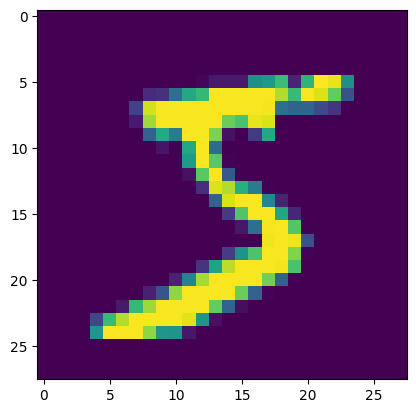

In [6]:
showing_tensor_images(x_train[0])

**Creating a generator Componets**
- linear transformation ( mapping to the another shape ).
- Batch Normalization ( stabilization ).
- Non-linear activation ( the output can be transformed into complex world ).

In [79]:
### Creating a generator Network
class generator_block(keras.layers.Layer):

  def __init__(self, output_dims, **kwargs):
    super().__init__(**kwargs)
    self.linear = keras.layers.Dense(output_dims)
    self.bn = keras.layers.BatchNormalization()
    self.act = keras.layers.Activation("relu")

  def call(self, inputs):
    x = self.linear(inputs)
    x = self.bn(x)
    x = self.act(x)
    return x




In [10]:
### Sanity-checks
gen_b = generator_block(10)
out = gen_b(x_train[:1])

### Generator
Inputs:
  1. The Noise vector dimensions
  2. The Image dimensions
  3. The initial hidden dimensions

In [120]:

class Generator(keras.Model):

  def __init__(self, intial_dims = 64, output_dims = 784, **kwargs):
    super().__init__(**kwargs)
    self.flatten = keras.layers.Flatten()
    self.gen_b1 = generator_block(intial_dims)
    self.dropout1 = keras.layers.Dropout(0.4)
    self.gen_b2 = generator_block(intial_dims * 2)
    self.dropout2 = keras.layers.Dropout(0.5)
    self.gen_b3 = generator_block(intial_dims *4)
    self.dropout3 = keras.layers.Dropout(0.3)
    self.gen_b4 = generator_block(output_dims)
    self.reshape = tf.keras.layers.Reshape(target_shape = (28,28,1))

  def call(self, inputs):
    x = self.flatten(inputs)
    x = self.gen_b1(x)
    # x = self.dropout1(x)
    x = self.gen_b2(x)
    # x = self.dropout2(x)
    x = self.gen_b3(x)
    # x = self.dropout3(x)
    x = self.gen_b4(x)
    x = self.reshape(x)
    return x


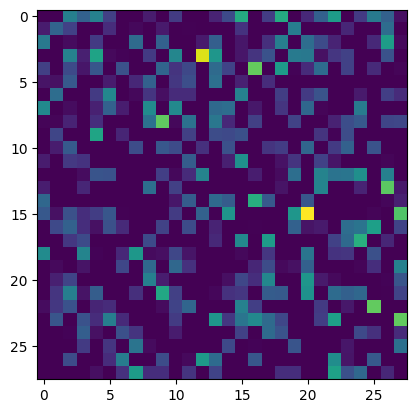

In [121]:
### Sanity-Checking
'''
  1. Creating the random noise (it is an input)
  2. passing the input to the generator
  3. get the output from the generator
  4. plot the output image through the image plot.
'''
noise = tf.random.normal(shape = (1, 64), mean = 0, stddev = 1)
generator = Generator()
output = generator(noise)
plt.imshow(output[0])

#### Creating a Noise

In [122]:
### creating a random noise
def get_noise(n_samples, n_dims, std_dev, mean, device = "cpu"):
  return tf.random.normal(shape = (n_samples, n_dims), mean = mean, stddev = std_dev)

### Discriminator
- Here we will use the Leaky Relu ( which will deactivate )

In [138]:
### discriminator component
class discrimnator_block(keras.layers.Layer):

  def __init__(self, n_dims, **kwargs):
    super().__init__(**kwargs)
    self.linear = keras.layers.Dense(n_dims)
    self.act = keras.layers.LeakyReLU(alpha = 0.5)

  def call(self,inputs):
    x = self.linear(inputs)
    x = self.act(x)
    return x


In [124]:
### Building the Dsiscriminator using the discriminator blocks

class Discriminator(keras.Model):

  def __init__(self, input_dims = 32, ouput_dims = 1, **kwargs):
    super().__init__(**kwargs)
    self.flatten = keras.layers.Flatten()
    self.disc_b1 = discrimnator_block(input_dims * 4)
    self.dropout1 = keras.layers.Dropout(0.4)
    self.disc_b2 = discrimnator_block(input_dims * 2)
    self.dropout2 = keras.layers.Dropout(0.5)
    self.disc_b3 = discrimnator_block(input_dims)
    self.dropout3 = keras.layers.Dropout(0.7)

    self.disc_b4 = keras.layers.Dense(1, activation = "sigmoid")

  def call(self, inputs):
    x = self.flatten(inputs)
    x = self.disc_b1(x)
    # x = self.dropout1(x)
    x = self.disc_b2(x)
    # x = self.dropout2(x)
    x = self.disc_b3(x)
    # x = self.dropout3(x)
    x = self.disc_b4(x)
    return x


In [125]:
### sanity checks
discriminator = Discriminator()
output = discriminator(x_train[:1])

In [126]:
output

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[1.8669352e-15]], dtype=float32)>

### Training
**Essentials for the training the network**
- criterion => loss function (cross entropy and econstruction loss, KL divergence )
- n_epochs
- z_dims => dimension of noise vector.
- batch_size => the batch size of the training steps
- lr => learnining rate
- device => CPU / GPU


In [127]:
criterion = keras.losses.BinaryCrossentropy()
n_epochs = 5
z_dims = 64
batch_size = 128
lr = 0.00004
device = "cpu"

In [128]:
### reshaping the training  and validation dataset
x_train = np.expand_dims(x_train, axis = -1)
y_train = np.expand_dims(y_train, axis = -1)

In [129]:
### Data Loaders

## converting the features in to the tensors
features = tf.convert_to_tensor(x_train)
labels = tf.convert_to_tensor(y_train)

dataloaders = tf.data.Dataset.from_tensor_slices((features, labels))
dataloaders = dataloaders.batch(batch_size)


In [130]:
### Gettiing the generator and the discriminator
gen_network = Generator()
gen_optimizer = keras.optimizers.Adam(learning_rate=lr)

dis_network = Discriminator()
dis_optimizer = keras.optimizers.Adam(learning_rate = lr)

#### Defining the Losses
- Discriminator loss
- Generaotr loss

In [131]:
### For the samplpe GANs we are using the same losses
### i.e For discriminator and generator ==> we are using the Binary Cross Entropy Losses

discriminator_criterion = keras.losses.BinaryCrossentropy(from_logits = False)
generator_criterion = keras.losses.BinaryCrossentropy(from_logits = False)


def discriminator_loss(real_outputs, fake_outputs):
  ## discriminator loss ==> cross entropy
  real_labels = tf.ones(shape = (real_outputs.shape[0], 1))
  fake_labels = tf.zeros(shape = (fake_outputs.shape[0], 1))

  real_loss = discriminator_criterion(real_labels, real_outputs)
  fake_loss =discriminator_criterion(fake_labels, fake_outputs)

  return (real_loss + fake_loss)/2


def generater_loss(fake_outputs):
  ## generator loss => cross entropy
  labels = tf.ones(shape = (fake_outputs.shape[0], 1))
  loss = generator_criterion(labels, fake_outputs)
  return loss



In [132]:
### Training steps for finding the forward pass and backward pass to the generator and discriminator.
for epoch in range(n_epochs):
  step = 0
  print("Epoch : {}/{} ".format(epoch, n_epochs))
  for real, _ in dataloaders:
    ### training discriminator
    noise_random = get_noise(n_samples = real.shape[0], n_dims=z_dims, std_dev=1, mean=0)

    ### Forward pass
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:

      fake_outs = gen_network(noise_random)

      disc_outs_fake = dis_network(fake_outs)
      disc_outs_real = dis_network(real)

      disc_loss = discriminator_loss(disc_outs_real, disc_outs_fake)
      gen_loss = generater_loss(disc_outs_fake)

    ### Backward pass by optimizer and loss
    disc_grads = disc_tape.gradient(disc_loss, dis_network.trainable_variables)
    dis_optimizer.apply_gradients(zip(disc_grads, dis_network.trainable_variables))

    gen_grads = gen_tape.gradient(gen_loss, gen_network.trainable_variables)
    gen_optimizer.apply_gradients(zip(gen_grads, gen_network.trainable_variables))

    step += 1
    if(step%50 == 0):
      print("\t|| discriminator_loss : {}, generator_loss : {} ".format(disc_loss, gen_loss))



Epoch : 0/5 
	|| discriminator_loss : 1.1306486129760742, generator_loss : 0.27275729179382324 
	|| discriminator_loss : 1.1649426221847534, generator_loss : 0.11189033091068268 
	|| discriminator_loss : 2.1908395290374756, generator_loss : 0.051600031554698944 
	|| discriminator_loss : 1.826185703277588, generator_loss : 0.033158060163259506 
	|| discriminator_loss : 1.9636383056640625, generator_loss : 0.025267034769058228 
	|| discriminator_loss : 2.1509788036346436, generator_loss : 0.020448345690965652 
	|| discriminator_loss : 2.2183516025543213, generator_loss : 0.016575295478105545 
	|| discriminator_loss : 2.3893158435821533, generator_loss : 0.013374336063861847 
	|| discriminator_loss : 2.3851945400238037, generator_loss : 0.01337725855410099 
Epoch : 1/5 
	|| discriminator_loss : 2.4505057334899902, generator_loss : 0.014621427282691002 
	|| discriminator_loss : 2.419175863265991, generator_loss : 0.019272271543741226 
	|| discriminator_loss : 2.372509717941284, generator_l

In [133]:
s = get_noise(1, 64, 1, 0)

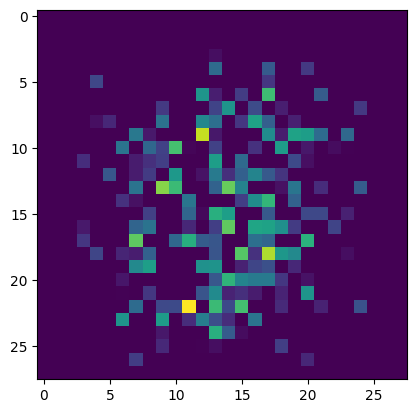

In [134]:

# generator = Generator()
output = gen_network(noise)
plt.imshow(tf.reshape(output, shape=(28,28,1)))

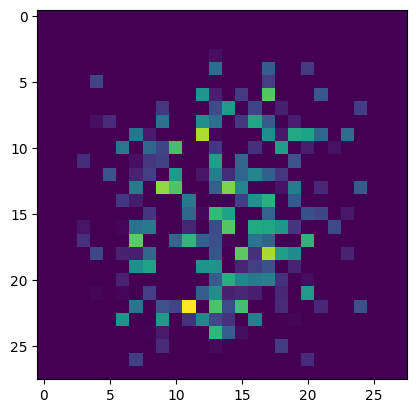

In [136]:
noise = tf.random.normal(shape = (1, 64), mean = 0, stddev = 1)
output = gen_network(noise)
# output = generator(noise)
plt.imshow(output[0])